# Trabalho Prático da disciplina de Análise de Dados Não Estruturados (2022/2023) - Primeira Parte

Neste tutorial irei explicar como utilizar as bibliotecas Tensorflow e Keras para contruir um Multilayer Percetron (MLP) e uma Rede Neuronal Convolucional (CNN), tilizando o dataset CIFAR-100.
O tutorial visa, essencialmente, responder a três perguntas, cujas respostas serão fundamentadas com base teórica, tendo em consideração a matéria lecionada até agora nas aulas de Análise de Dados Não Estruturados.

**Pergunta 1: Fazer o carregamento do CIFAR-100 dataset, explorar as labels e os dados de imagens. Mencionar algum aspeto interessante encontrado durante essa exploração.**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import datasets
from tensorflow.keras import utils, models
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard

O CIFAR-100 contém 60000 imagens a cores, com dimensão 32 X 32 píxeis, cada uma das imagens pertencente a uma de 100 classes, com 600 imagens por classe. As classes estão divididas em 20 super classes, cada uma contendo 5 classes fine-grained. Uma das características que podemos aferir ao consultar e analisar o dataset é o tamanho das imagens. Todas as imagens do datset têm um tamanho de 32 X 32 píxeis. Outra é a cor das imagens. Cada imagem é uma imagem a cores, com três canais de cor (RGB). Como já mencionado, o dataset possui 100 classes fine-grained, onde cada uma representa uma categoria de objecto diferente. Essas 100 classes estão agrupadas em 20 super classes.
O dataset está dividido num conjunto de treino de 50000 imagens e num conjunto de teste de 10000 imagens. Para visualizar melhor as imagens presentes no dataset, foi criada a função exemplos() que mostra 9 imagens aleatórias do conjunto de treino e as respetivas labels.

In [ ]:
# Print the shape of the training and test sets
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="coarse")
(x_100, y_100), (x_t_100, y_t_100) = cifar100.load_data(label_mode="fine")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Print the number of unique labels in the dataset
print('Number of unique labels (Coarse):', len(set(y_train.flatten())))
print('Number of unique labels (Fine):', len(set(y_100.flatten())))

# Transformação dos dados de treino e teste
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
Number of unique labels (Coarse): 20
Number of unique labels (Fine): 100


<ipython-input-34-fd2728e42683>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, i+1)


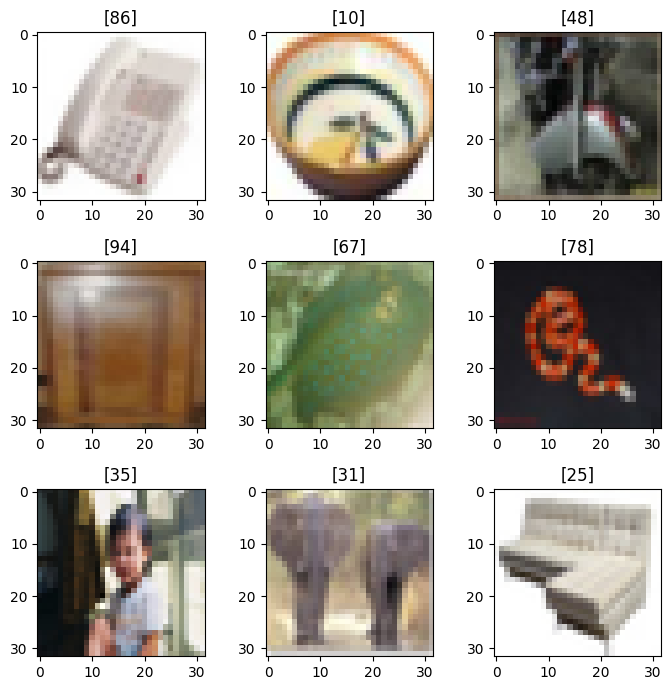

In [ ]:
def exemplos(dat, lab):
    plt.subplots(figsize=(7, 7))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        k = np.random.randint(0, dat.shape[0])
        plt.title(lab[k])
        plt.imshow(dat[k])
    plt.tight_layout()
    plt.show()

exemplos(x_train, y_train)

**Pergunta 2: Devenvolver um Multilayer Perceptron para classificar as imagens usando as coarse labels. Experimentar diferentes esquemas de inicializações, optimizações e normalizações. Reportar qual é que funcionou melhor e mencionar o possível porquê.**

O Multilayer Perceptron (MLP) utilizado na neste problema de classificação é consituído por sete layers, uma de entrada, uma de saída e cinco hidden layers densas. O critério para uso inicial desta arquitetura de rede neuronal foi seguir a regra de geometria em pirâmide. O modelo utilizado foi o modelo Sequencial, que normalmente é utilizado quando o modelo tem apenas um tensor como input e um tensor como output, e não vários (neste caso seria mais apropriado utilizar o modelo Funcional).

A ativação utilizada em todas as layers, à exceção da output layer, foi a ReLu. Esta ativação permite evitar o problema de vanishing gradients e introduz a não-linearidade ao modelo, permitindo que o mesmo descubra características entre o input features e o output. Após comparado com outras ativações, nomeadamente, a LeakyRelu e a Sigmoid, foi possível verificar que o modelo convergia muito mais cedo, o que originou uma maior eficiência do mesmo. O facto de ter utilizado a ReLU como função de ativação nesta layers, levou-me a utilizar a initialização de He Normal, o que acaba por ser o recomendado pela literatura. A ativação utilizada na última layer foi a Softmax. Esta função de ativação é frequentemente utilizada na última camada de uma rede neuronal quando estamos perante um problema de multi-classificação e porque o resultado pode ser interpretado como uma distribuição de probabilidades.

Foram adicionadas camadas de normalização de batch após cada camada densa. Através do treino do modelo foi possível verificar que as mesmas melhoraram a velocidade de treino do modelo e ajudaram generalizar melhor o mesmo, o que permitiu obter melhores valores de accuracy na validação. Foram adicionadas, entre cada layer densa, uma layer Dropout com o rate de 0.25. Esta layer fará com que 1/4 das unidades de input (aleatoriamente) fique com o valor de zero, a cada step da fase de treino do modelo, permitindo que o modelo generalize melhor.

Como otimizador, utilizei o Adam com um learning rate de 0.01. Este learning rate é superior ao padrão (0.001), contudo não há problema em usar pois o tamanho dos meus batches é alto (512). A razão para isso é que, ao usar bathes maiores, os gradientes calculados em cada batch são mais representativos dos gradientes verdadeiros da loss function do que quando se usam batchs mais reduzidos. Quando os gradientes são menos noisy, o algoritmo de otimização pode dar steps maiores em direcção ao mínimo da loss function. Após ter treinado com os dois valores de learning rate, verificou-se que os melhores valores de accuracy na validação foram obtidos com 0.01. Como loss funtion foi utilizada a SparseCategoricalCrossentropy(), pois é um modelo de multi-classificação e as labels dadas ao modelo não estão no formato de one-hot encoded. A métrica que se tomou em consideração foi a accuracy.

In [ ]:
def model_mlp(opt):
  model = Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.Dense(3072, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(20, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal()))
  # Compile do modelo
  model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
  return model

Para correr e gravar dados importante do modelo, foi criada a função run_save_mlp(). A função tem como parâmetros de entrada o número de batches e de epochs. Esta função permite correr o modelo para o número de batches e epochs mencionados, e com o otimizador escolhido, que neste caso é o Adam com learning rate de 0.01. Permite gravar os parâmetros, configurações e arquitetura do modelo num ficheiro com o nome 'mlp_f.h5'. Para cada epoch, é possível verificar os valores de loss e accuracy para as fases de treino e de validação so modelo. Foi escolhido o batch de 512 pois, pelos motivos já mencionados acima. O número de epochs escolhido foi 300. É provável que, caso tivesse corrido para mais epochs, o modelo não tivesse obtido melhores muito diferentes dos atuais.

In [ ]:
def run_save_mlp(bat, epo):
    model_mlp_run=model_mlp(opt=Adam(learning_rate=0.01))
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model_mlp_run.fit(x_train, y_train, validation_split=0.2, batch_size=bat, epochs=epo, callbacks=[tensorboard_cb])
    model_mlp_run.save('mlp_final.h5')
    model_mlp_run_json = model_mlp_run.to_json()
    with open("mlp_final.json", "w") as json_file:
        json_file.write(model_mlp_run_json)
    return history

history = run_save_mlp(bat=512, epo=300)

Epoch 1/300
79/79 [==============================] - 6s 22ms/step - loss: 2.8625 - accuracy: 0.1551 - val_loss: 17.0947 - val_accuracy: 0.1117
Epoch 2/300
79/79 [==============================] - 1s 17ms/step - loss: 2.5082 - accuracy: 0.2160 - val_loss: 3.0666 - val_accuracy: 0.1972
Epoch 3/300
79/79 [==============================] - 1s 17ms/step - loss: 2.4022 - accuracy: 0.2524 - val_loss: 2.4791 - val_accuracy: 0.2576
Epoch 4/300
79/79 [==============================] - 1s 17ms/step - loss: 2.3346 - accuracy: 0.2752 - val_loss: 2.4443 - val_accuracy: 0.2662
Epoch 5/300
79/79 [==============================] - 1s 17ms/step - loss: 2.2771 - accuracy: 0.2907 - val_loss: 2.3304 - val_accuracy: 0.2803
Epoch 6/300
79/79 [==============================] - 1s 17ms/step - loss: 2.2417 - accuracy: 0.3047 - val_loss: 2.4089 - val_accuracy: 0.2709
Epoch 7/300
79/79 [==============================] - 1s 17ms/step - loss: 2.1985 - accuracy: 0.3178 - val_loss: 2.3455 - val_accuracy: 0.2861
Epoch

Para avaliar visualmente a performance do modelo, foram criados dois gráficos. O primeiro, Cross Entropy Loss, onde estão as curvas dos valores de loss do treino (azul) e de validação (laranja), por cada epoch (1 a 300). O segundo, Classification Accuracy, onde estão as curvas de accuracy do treino (azul) e de validação (laranja), também por cada epoch (1 a 300). É possível concluir que o modelo acaba por entrar em overfitting muito cedo. A curva de validação não converge, e estabiliza-se muito cedo em torno dos valores de 0.38. A mesma acaba por se separar da curva de treino ainda antes das 25 epochs, acabando o modelo por não conseguir generalizar. Foram afinados vários parâmetros, como o learning rate, batch size, percentagem de dropout, entre outros, bem como testados várias arquiteturas de modelo. Os melhores valores obtidos foram com esta configuração. Estima-se que o facto de serem 20 classes de classificação, não permita o modelo obter melhores métricas, com esta complexidade de modelo. Após correr o modelo para os dados de teste, as métricas obtidas foram: Loss = 3.185326099395752 e Accuracy: 0.40779998898506165.


In [ ]:
##### FASE DE TESTE #####
model_mlp_run = load_model('mlp_final.h5')
print('Teste para o Modelo MLP:')
loss_metrics1 = model_mlp_run.evaluate(x_test, y_test, verbose=2, batch_size=512)
print('Loss:', loss_metrics1[0], 'Accuracy:',loss_metrics1[1])

Teste para o Modelo MLP:
20/20 - 0s - loss: 3.1853 - accuracy: 0.4078 - 292ms/epoch - 15ms/step
Loss: 3.185326099395752 Accuracy: 0.40779998898506165


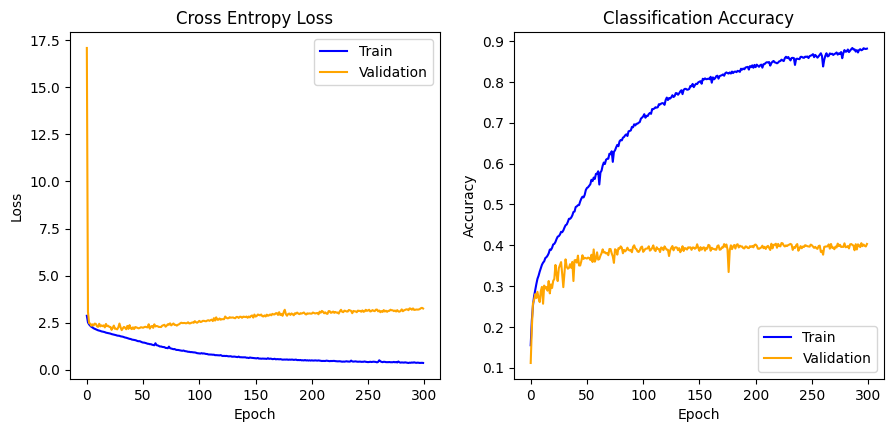

In [ ]:
def plots(history, epochs):
    a_epochs=np.arange(epochs)
    # Plot Loss
    plt.figure(figsize=(10.5,4.5))
    plt.subplot(1, 2, 1)
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(a_epochs,history.history['loss'], color='blue', label='Train')
    plt.plot(a_epochs,history.history['val_loss'], color='orange', label='Validation')
    plt.legend(loc="upper right")
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(a_epochs,history.history['accuracy'], color='blue', label='Train')
    plt.plot(a_epochs,history.history['val_accuracy'], color='orange', label='Validation')
    plt.legend(loc="lower right")
    plt.show()

plots(history, 300)

**Pergunta 3: Devenvolver um Rede Neuronal Convolucional para classificar as imagens usando as coarse labels. Experimentar diferentes esquemas de inicializações, optimizações e normalizações. Reportar qual é que funcionou melhor e mencionar o possível porquê. Compara os resultados da CNN e do MLP e explica a diferença de desempenho e capacidade.**

Nesta parte foi igualmente utilizado um modelo sequencial. Foi criada a função model_cnn(), que recebe apenas um parâmetro relativo ao otimizador utilizado. O motivo pelo qual foi escolhido apenas este parâmetro de entrada tem a ver com o tuning final que foi feito ao mesmo. Os dados de input dados à rede são na forma de (32, 32, 3), correspondente à dimenção das imegens a cores (RGB).

A rede possui seis operações convolucionais (duas de 128 filtros, duas de 256 e mais duas de 512). Os blocos de operações convolucionais são os três muito semelhantes, possuindo o mesmo modo de ativação ReLU, o kernel (3,3), padding='same' e a inicialização de pesos através da distribuição normal de He. Após cada bloco de convulções, é aplicada uma layer de normalização de batches, uma pooling layer (MaxPooling2D) e uma layer de Dropout (0.5). A rede possui ainda uma camada Flatten, que transforma os dados de input para uma dimensão (1D) e um bloco quatro camadas densas, fully connected, com 1024, 512, 256 e 20 unidades, respetivamente. Todas elas possuem modo de ativação ReLU, inicialização de pesos através da distribuição normal de He, uma layer que faz a normalização dos batches e uma layer de Dropout (0.5).
As unidades da última layer correspondem ao número de classificações que queremos fazer, 20. É utilizado, aqui, uma ativação softmax, o que nos permite obter como output uma distribuição de probabilidades para cada uma das classes em estudo.

Para abordar este problema, foi idealizado contruir uma rede de convoluções que fosse crescendo em número de unidades, mantendo o mesmo kernel (3,3), que corresponde ao filtro mais comum utilizado para extrair as features das imagens, e o mesmo kernel initializer (HeNormal), que em todos os teste demonstrou maior capacidade na convergência dos modelos e rapidez do treino.
Visto que utilizei essa inicialização de He, optei por escolher a activação ReLU, que me previne o problema de vanishing gradients. Comparativamente com o Leaky ReLU, posso afirmar que usando o ReLU o modelo convergiu mais rápido, obrigando a menos tempo de treino. Esta ativação adiciona a não-lineariade ao modelo, possibilitando que o mesmo aprenda mapas mais complexos e que retire mais características das features.

Como queria manter o output do tamanho do input map, utilizei o padding='same' e stride default (1,1). O stride (1,1) significa que, a cada operação da convolução (entre o filtro e o input map), o filtro anda um pixel para a direita, a cada convolução, até ao limite à direita do inpup map. Após chegar a esse limite à direita, desce um pixel e reinicia a mesma operação a partir do limite à esquerda, até completar todo o input map.
A layer de normalização de batches ajudou em muito o modelo. Nas primeiras tentativas de treino, o modelo estava preso nos valores de validation accuracy (por volta dos 0.60). Ao adicionar estas layer, após as convoluções, o modelo teve um elevado melhoramento na performance. Notou-se que a curva de loss function ficou muito mais suave, o treino foi acelerado e a validation accuracy melhorou bastante, o que indica um melhoramento claro do modelo.

Após cada conjunto de convoluções e batch normalization layer, foi introduzida uma pooling layer, nomeadamente, MaxPooling2D. Esta layer permite reter as features mais proeminentes do feature map, escolhendo os maiores valores. Ao escolher o maior valor dessa pooling, deixa de fora os restantes, acabando por reduzir a dimensão do feature map, ajudando também a prevenir o overfitting. Adicionalmente, a layer de Dropout (0.5) também ajudou a melhorar o modelo, tendo se verificado que o modelo generalizou muito melhor após a sua utilização logo a seguir às convoluções.

Depois dos três conjuntos de Convoluções+BatchNormalization+MaxPooling+Dropout, foi adicionada a layer Flatten, que serve para transformar os dados recebidos para uma dimensão (1D) e servir de input para a rede densa que será utilizada na classificação. À semelhança do MLP, foi utilizado o critério de geometria em pirâmide para construção da rede, iniciando com uma layer densa de 1024, seguida de outra de 512, 256 e 20. No final o modelo foi compilado. Foi utilizado o otimizador Adam com um learning rate de 0.001 (inserido na função run_save_cnn()). Este learning rate é o default do modelo e foi o que demonstrou melhores resultados em termos de convergência do modelo bem como de rapidez. Foi utilizada como loss functuion a CategoricalCrossentropy(), pois é a que se adequa melhor tendo em conta que as labels foram dadas ao modelo no formato de one-hot encoded e o modelo é de multi-classificação. A métrica que se tomou em consideração foi a accuracy.

In [ ]:
def model_cnn(opt):
  model_c = Sequential()
  model_c.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same", kernel_initializer=tf.keras.initializers.HeNormal(), input_shape=(32, 32, 3)))
  model_c.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same", kernel_initializer=tf.keras.initializers.HeNormal()))
  model_c.add(tf.keras.layers.BatchNormalization())
  model_c.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model_c.add(tf.keras.layers.Dropout(0.5))
  ##
  model_c.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same", kernel_initializer=tf.keras.initializers.HeNormal()))
  model_c.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same", kernel_initializer=tf.keras.initializers.HeNormal()))
  model_c.add(tf.keras.layers.BatchNormalization())
  model_c.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model_c.add(tf.keras.layers.Dropout(0.5))
  ##
  model_c.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding="same", kernel_initializer=tf.keras.initializers.HeNormal()))
  model_c.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding="same", kernel_initializer=tf.keras.initializers.HeNormal()))
  model_c.add(tf.keras.layers.BatchNormalization())
  model_c.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model_c.add(tf.keras.layers.Dropout(0.5))
  ##
  model_c.add(tf.keras.layers.Flatten())
  model_c.add(tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
  model_c.add(tf.keras.layers.BatchNormalization())
  model_c.add(tf.keras.layers.Dropout(0.5))
  model_c.add(tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
  model_c.add(tf.keras.layers.BatchNormalization())
  model_c.add(tf.keras.layers.Dropout(0.5))
  model_c.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
  model_c.add(tf.keras.layers.BatchNormalization())
  model_c.add(tf.keras.layers.Dropout(0.5))
  model_c.add(tf.keras.layers.Dense(20, activation='softmax'))
  # Compile do modelo
  model_c.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
  return model_c

Para correr e gravar dados importante do modelo, foi criada a função run_save_cnn(). A função tem como parâmetros de entrada o número de batches e de epochs. Esta função permite correr o modelo para o número de batches e epochs mencionados, e com o otimizador escolhido, que neste caso é o Adam com learning rate de 0.001. Permite gravar os parâmetros, configurações e arquitetura do modelo num ficheiro com o nome 'cnn_1.h5'. Para cada epoch, é possível verificar os valores de loss e accuracy para as fases de treino e de validação so modelo. Foi escolhido o batch de 64 pois, através dos vários treinos, chegou-se à conclusão que o uso de batches muito elevados (256, 512, 1024) degrada significativamente a qualidade do modelo, medida através da sua capacidade de generalização. O número de epochs escolhido foi 200. A razão prende-se com o equilíbrio entre a rapidez de treino do modelo e o atingir do plateau nos valores de accuracy da validação.

In [ ]:
def run_save_cnn(bat, epo):
    model_cnn_run=model_cnn(opt=Adam(learning_rate=0.001))
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history_c = model_cnn_run.fit(x_train, y_train_ohe, validation_split=0.2, batch_size=bat, epochs=epo, callbacks=[tensorboard_cb])
    model_cnn_run.save('cnn_final.h5')
    model_cnn_run_json = model_cnn_run.to_json()
    with open("cnn_final.json", "w") as json_file:
        json_file.write(model_cnn_run_json)
    return history_c

history_c = run_save_cnn(bat=64, epo=200)

Epoch 1/200
625/625 [==============================] - 19s 12ms/step - loss: 3.0395 - accuracy: 0.1453 - val_loss: 3.2246 - val_accuracy: 0.1332
Epoch 2/200
625/625 [==============================] - 7s 11ms/step - loss: 2.4956 - accuracy: 0.2324 - val_loss: 2.4980 - val_accuracy: 0.2344
Epoch 3/200
625/625 [==============================] - 7s 11ms/step - loss: 2.2399 - accuracy: 0.3040 - val_loss: 2.0099 - val_accuracy: 0.3710
Epoch 4/200
625/625 [==============================] - 7s 11ms/step - loss: 2.0069 - accuracy: 0.3720 - val_loss: 1.8859 - val_accuracy: 0.4035
Epoch 5/200
625/625 [==============================] - 7s 11ms/step - loss: 1.8186 - accuracy: 0.4265 - val_loss: 1.6839 - val_accuracy: 0.4679
Epoch 6/200
625/625 [==============================] - 7s 12ms/step - loss: 1.6793 - accuracy: 0.4733 - val_loss: 1.6608 - val_accuracy: 0.4823
Epoch 7/200
625/625 [==============================] - 7s 11ms/step - loss: 1.5849 - accuracy: 0.4997 - val_loss: 1.4548 - val_accuracy

Para avaliar visualmente a performance do modelo, foram criados dois gráficos. O primeiro, Cross Entropy Loss, onde estão as curvas dos valores de loss do treino (azul) e de validação (laranja), por cada epoch (1 a 200). O segundo, Classification Accuracy, onde estão as curvas de accuracy do treino (azul) e de validação (laranja), também por cada epoch (1 a 200). É possível concluir que o modelo acaba por entrar em overfitting. A curva de validação não converge, separando-se da curva de treino ainda antes das 50 epochs, acabando o modelo por não conseguir generalizar. Esta questão era ainda pior antes de se utilizar o Batch Normalization e com o Dropout após as layers de convoluções, tendo melhorado significativamente após isso. Usar o Early Stopping neste caso também poderia ser uma opção viável. Após correr o modelo para os dados de teste, as métricas obtidas foram: Loss = 1.3742414712905884 e Accuracy: 0.7422999739646912.

In [ ]:
##### FASE DE TESTE #####
model_cnn_run = load_model('cnn_final.h5')
print('Teste para o Modelo CNN:')
loss_metrics2 = model_cnn_run.evaluate(x_test, y_test_ohe, verbose=2, batch_size=64)
print('Loss:', loss_metrics2[0], 'Accuracy:',loss_metrics2[1])

Teste para o Modelo CNN:
157/157 - 1s - loss: 1.3742 - accuracy: 0.7423 - 864ms/epoch - 6ms/step
Loss: 1.3742414712905884 Accuracy: 0.7422999739646912


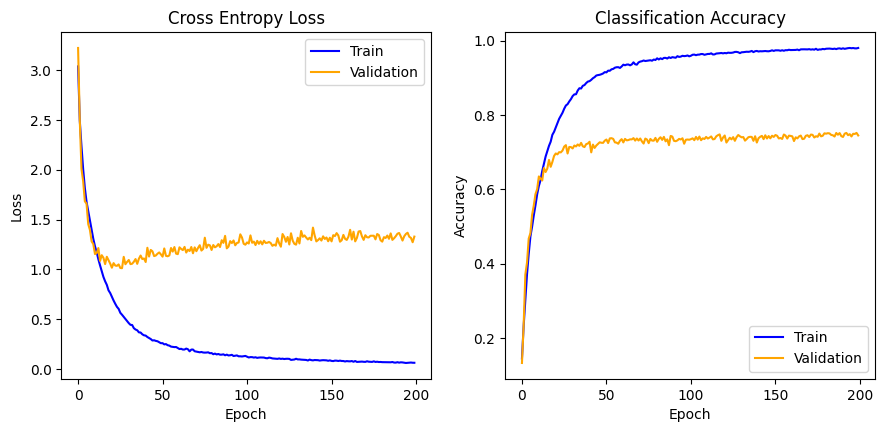

In [ ]:
def plots_c(history_c, epochs):
    a_epochs=np.arange(epochs)
    # Plot Loss
    plt.figure(figsize=(10.5,4.5))
    plt.subplot(1, 2, 1)
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(a_epochs,history_c.history['loss'], color='blue', label='Train')
    plt.plot(a_epochs,history_c.history['val_loss'], color='orange', label='Validation')
    plt.legend(loc="upper right")
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(a_epochs,history_c.history['accuracy'], color='blue', label='Train')
    plt.plot(a_epochs,history_c.history['val_accuracy'], color='orange', label='Validation')
    plt.legend(loc="lower right")
    plt.show()

plots_c(history_c, 200)

Como pudemos verificar, o modelo MLP teve um pior desempenho que o modelo CNN, e essencialmente devido às diferenças fundamentais nas arquitecturas destes dois modelos.

O MLP é bom na aprendizagem de padrões em dados estruturados, como dados numéricos, mas não é tão bom na aprendizagem de dados não estruturados como é o caso de imagens, porque exigem que as imagens sejam achatadas ("flattened") em vetores unidimensionais. Este processo de achatamento pode resultar numa perda de informação espacial, que é importante para o reconhecimento de padrões em imagens.

Por outro lado, modelos CNN foram concebidos especificamente para o processamento de imagens. Estes modelos são constituídos por várias camadas convolucionais, seguidas de camadas de pooling e algumas camadas fully connected. As camadas convolucionais utilizam filtros para extrair características das imagens, preservando a informação espacial (uma grande diferença para os MLP). As camadas de pooling reduzem a dimensionalidade dos feature maps e as fully connected layers efectuam a classificação.

Outra característica importante que permite melhores performances quando se utiliza CNN é a translation invariance. Estes, independentemente onde esteja o padrão na imagem, conseguem reconhecê-lo, ao contrário do MLP que não possuem essa característica e que as imagens de input sejam pré-processadas para detetar padrões em locais diferentes.

Outra característica importante é a utilização de parâmetros entre os dois modelos. Os CNN utilizam menos parâmetros que os MLP, tornando-os mais fáceis de treinar e com menos tendência a entrarem em overfitting. Isto deve ao facto, essencialmente, dos CNN utilizarem pooling layers que reduzem a dimensionalidade do input data, acabando assim, também, por generalizar melhor.